# Battery Performance Analysis and SOC predictions for Lithium-Ion Batteries

**Note:** Due to time constraints, this analysis focuses solely on the State of Charge (SOC) and does not include estimations or analysis of State of Health (SOH), Remaining Useful Life (RUL), or Depth of Discharge (DOD).

## Project Overview
This project aims to analyze battery degradation data to assess and predict the State of Charge (SOC) of lithium-ion batteries. Insights gained from this analysis will aid in battery management decisions, enhancing battery longevity and performance.

## Data Description
The dataset comprises time-series data from lithium-ion cell tests, which include measurements of voltage, charge, and temperature across various cycles.

## Steps Outline

### Step 1: Data Understanding
- **Objective**: Acquaint with the dataset, exploring its structure, contents, and domain-specific aspects.

### Step 2: Data Cleaning and Preprocessing
- **Objective**: Address minimal missing values and rectify any missing cycle data in preparation for modeling.

### Step 3: Analysis of SOC
- **Objective**: Conduct statistical and regression analyses to visualize and understand SOC variations across different cells.

### Step 4: Feature Engineering and Algorithm Development
- **Objective**: Develop predictive models for SOC using ensemble methods like LightGBM and deep learning approaches like LSTM. Utilize libraries such as Darts for leveraging past and future covariates, and employ Optuna for hyperparameter tuning.
- **Tools**: Darts, Optuna, LightGBM, LSTM

### Step 5: Theoretical Deployment Using KServe
- **Objective**: Discuss theoretical deployment strategies for scaling the models using Kubernetes (Kubeflow + KServe), focusing on large-scale applications. (Note: Actual implementation not included due to time constraints.)

## Conclusion
The analysis provides actionable insights into optimizing battery usage and extending battery life, which are vital for advancing energy technologies.


### Step 1: Data Understanding

In [ ]:
import scipy.io
# Layer 1
# Replace 'path_to_file.mat' with the path to your .mat file
data = scipy.io.loadmat('/home/mibcat02/RandD%20-%20Data%20science/chicago_taxi/nitish/research/Oxford_Battery_Degradation_Dataset_1.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])


#### The .mat file contains the 4 layers of data related to 8 cells (eight commercial Kokam pouch cells).
* Each cell has the capacity of 740 mAh and were tested in a constant temperature environment of 40 degrees.
* Each cell was tested using 1-C Charge/Discharge (Standard charge and discharge at a current of 740mA) and Pseudo-OCV Charge/Discharge (A slower charging and discharging process at 40mA)
* Detailed measurements for each cycle including time, voltage, charge, and temperature for every 100 drive cycles

In [ ]:
# Structure of data for 'Cell1'
# As we can see it has cycles until 8200 (Layer 2)
cell1_data = data['Cell1']
print(type(cell1_data))
print(cell1_data.dtype)

<class 'numpy.ndarray'>
[('cyc0000', 'O'), ('cyc0100', 'O'), ('cyc0200', 'O'), ('cyc0300', 'O'), ('cyc0400', 'O'), ('cyc0500', 'O'), ('cyc0600', 'O'), ('cyc0700', 'O'), ('cyc0800', 'O'), ('cyc0900', 'O'), ('cyc1000', 'O'), ('cyc1100', 'O'), ('cyc1200', 'O'), ('cyc1300', 'O'), ('cyc1400', 'O'), ('cyc1600', 'O'), ('cyc1800', 'O'), ('cyc1900', 'O'), ('cyc2000', 'O'), ('cyc2100', 'O'), ('cyc2200', 'O'), ('cyc2300', 'O'), ('cyc2400', 'O'), ('cyc2500', 'O'), ('cyc2600', 'O'), ('cyc2700', 'O'), ('cyc2800', 'O'), ('cyc2900', 'O'), ('cyc3000', 'O'), ('cyc3100', 'O'), ('cyc3200', 'O'), ('cyc3300', 'O'), ('cyc3500', 'O'), ('cyc3600', 'O'), ('cyc3700', 'O'), ('cyc3800', 'O'), ('cyc3900', 'O'), ('cyc4000', 'O'), ('cyc4100', 'O'), ('cyc4200', 'O'), ('cyc4300', 'O'), ('cyc4400', 'O'), ('cyc4500', 'O'), ('cyc4600', 'O'), ('cyc4800', 'O'), ('cyc5000', 'O'), ('cyc5100', 'O'), ('cyc5200', 'O'), ('cyc5300', 'O'), ('cyc5400', 'O'), ('cyc5500', 'O'), ('cyc5600', 'O'), ('cyc5700', 'O'), ('cyc5800', 'O'), ('c

In [ ]:
# Layer 3
cycle_100_data = cell1_data['cyc0100'][0,0]
print(cycle_100_data.dtype)

[('C1ch', 'O'), ('C1dc', 'O'), ('OCVch', 'O'), ('OCVdc', 'O')]


##### For each battery cycle dataset, the following data is available: [('C1ch', 'O'), ('C1dc', 'O'), ('OCVch', 'O'), ('OCVdc', 'O')]

* C1ch - 1-C Charge:  This refers to charging the battery at a rate that would fully charge it in one hour, based on its capacity
* C1dc - 1-C Discharge: This refers to discharging the battery at a rate that would fully discharge it in one hour, based on its capacity
* OCVch - Pseudo-OCV Charge: This refers to a slower charging process that takes 20 hours to fully charge the battery
* OCVdc - Pseudo-OCV Discharge: This refers to a slower discharging process that takes 20 hours to fully discharge the battery

In [ ]:
# Extracting time and voltage from the 1-C charge phase of the 100th cycle to visualize the dataset
# Layer 4
time = cycle_100_data['C1ch'][0,0]['t'][0,0].flatten()
voltage = cycle_100_data['C1ch'][0,0]['v'][0,0].flatten()
voltage_discharge = cycle_100_data['C1dc'][0,0]['v'][0,0].flatten()
charge = cycle_100_data['C1ch'][0,0]['q'][0,0].flatten()
Temperature = cycle_100_data['C1ch'][0,0]['T'][0,0].flatten()

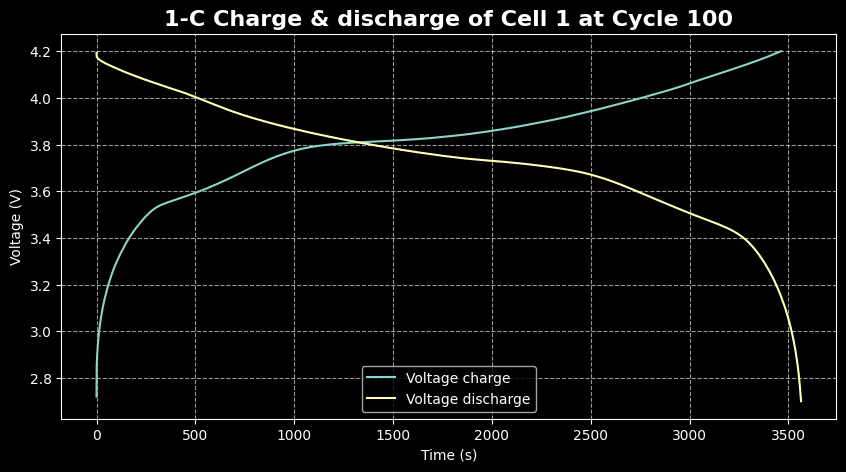

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.plot(voltage)
plt.plot(voltage_discharge)
plt.title('1-C Charge & discharge of Cell 1 at Cycle 100', fontsize=16, fontweight='bold')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend(['Voltage charge','Voltage discharge'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

#### Let plot the discharge voltage curves of all the cycles in the full lifespan for Cell 1 in the Oxford dataset

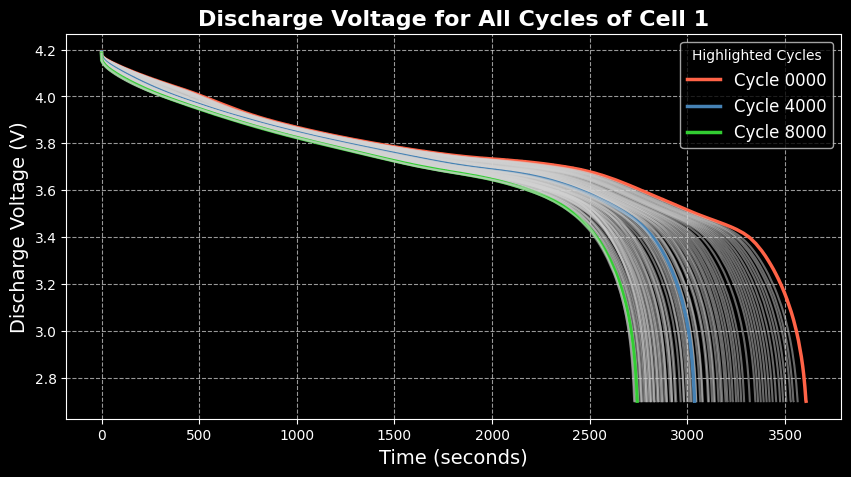

In [ ]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
cell1_data = data['Cell1']

plt.figure(figsize=(10, 5))
plt.style.use('dark_background')

highlight_colors = {'cyc0000': '#FF6347', 'cyc4000': '#4682B4', 'cyc8000': '#32CD32'}
default_color = '#D3D3D3'

for cycle_name in cell1_data.dtype.names:
    cycle_data = cell1_data[cycle_name][0, 0]
    if 'C1dc' in cycle_data.dtype.names:
        voltage = cycle_data['C1dc'][0, 0]['v'][0, 0].flatten()

        if cycle_name in highlight_colors:
            plt.plot(voltage, label=f'Cycle {cycle_name[3:]}', linewidth=2.5, color=highlight_colors[cycle_name])
        else:
            plt.plot(voltage, color=default_color, alpha=0.5)

plt.title('Discharge Voltage for All Cycles of Cell 1', fontsize=16, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=14)
plt.ylabel('Discharge Voltage (V)', fontsize=14)
plt.legend(title="Highlighted Cycles", title_fontsize='10', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Step 2: Data Cleaning and Preprocessing
* In this step, the focus will be on addressing missing cycle data and null values to prepare the dataset for modeling in Step 4. While additional cleaning could be undertaken, for the purposes of this project, the effort will be concentrated specifically on rectifying missing cycles information.

### step 3: Analysis of SOC, SOH, and DOD
* SOC: Often calculated as the percentage of the maximum charge capacity that the battery can hold at any given time.
* SOH: Measured as a percentage of the battery’s total capacity relative to its original capacity.
* DOD: Complementary to SOC, it reflects the percentage of the battery that has been discharged relative to the total capacity.

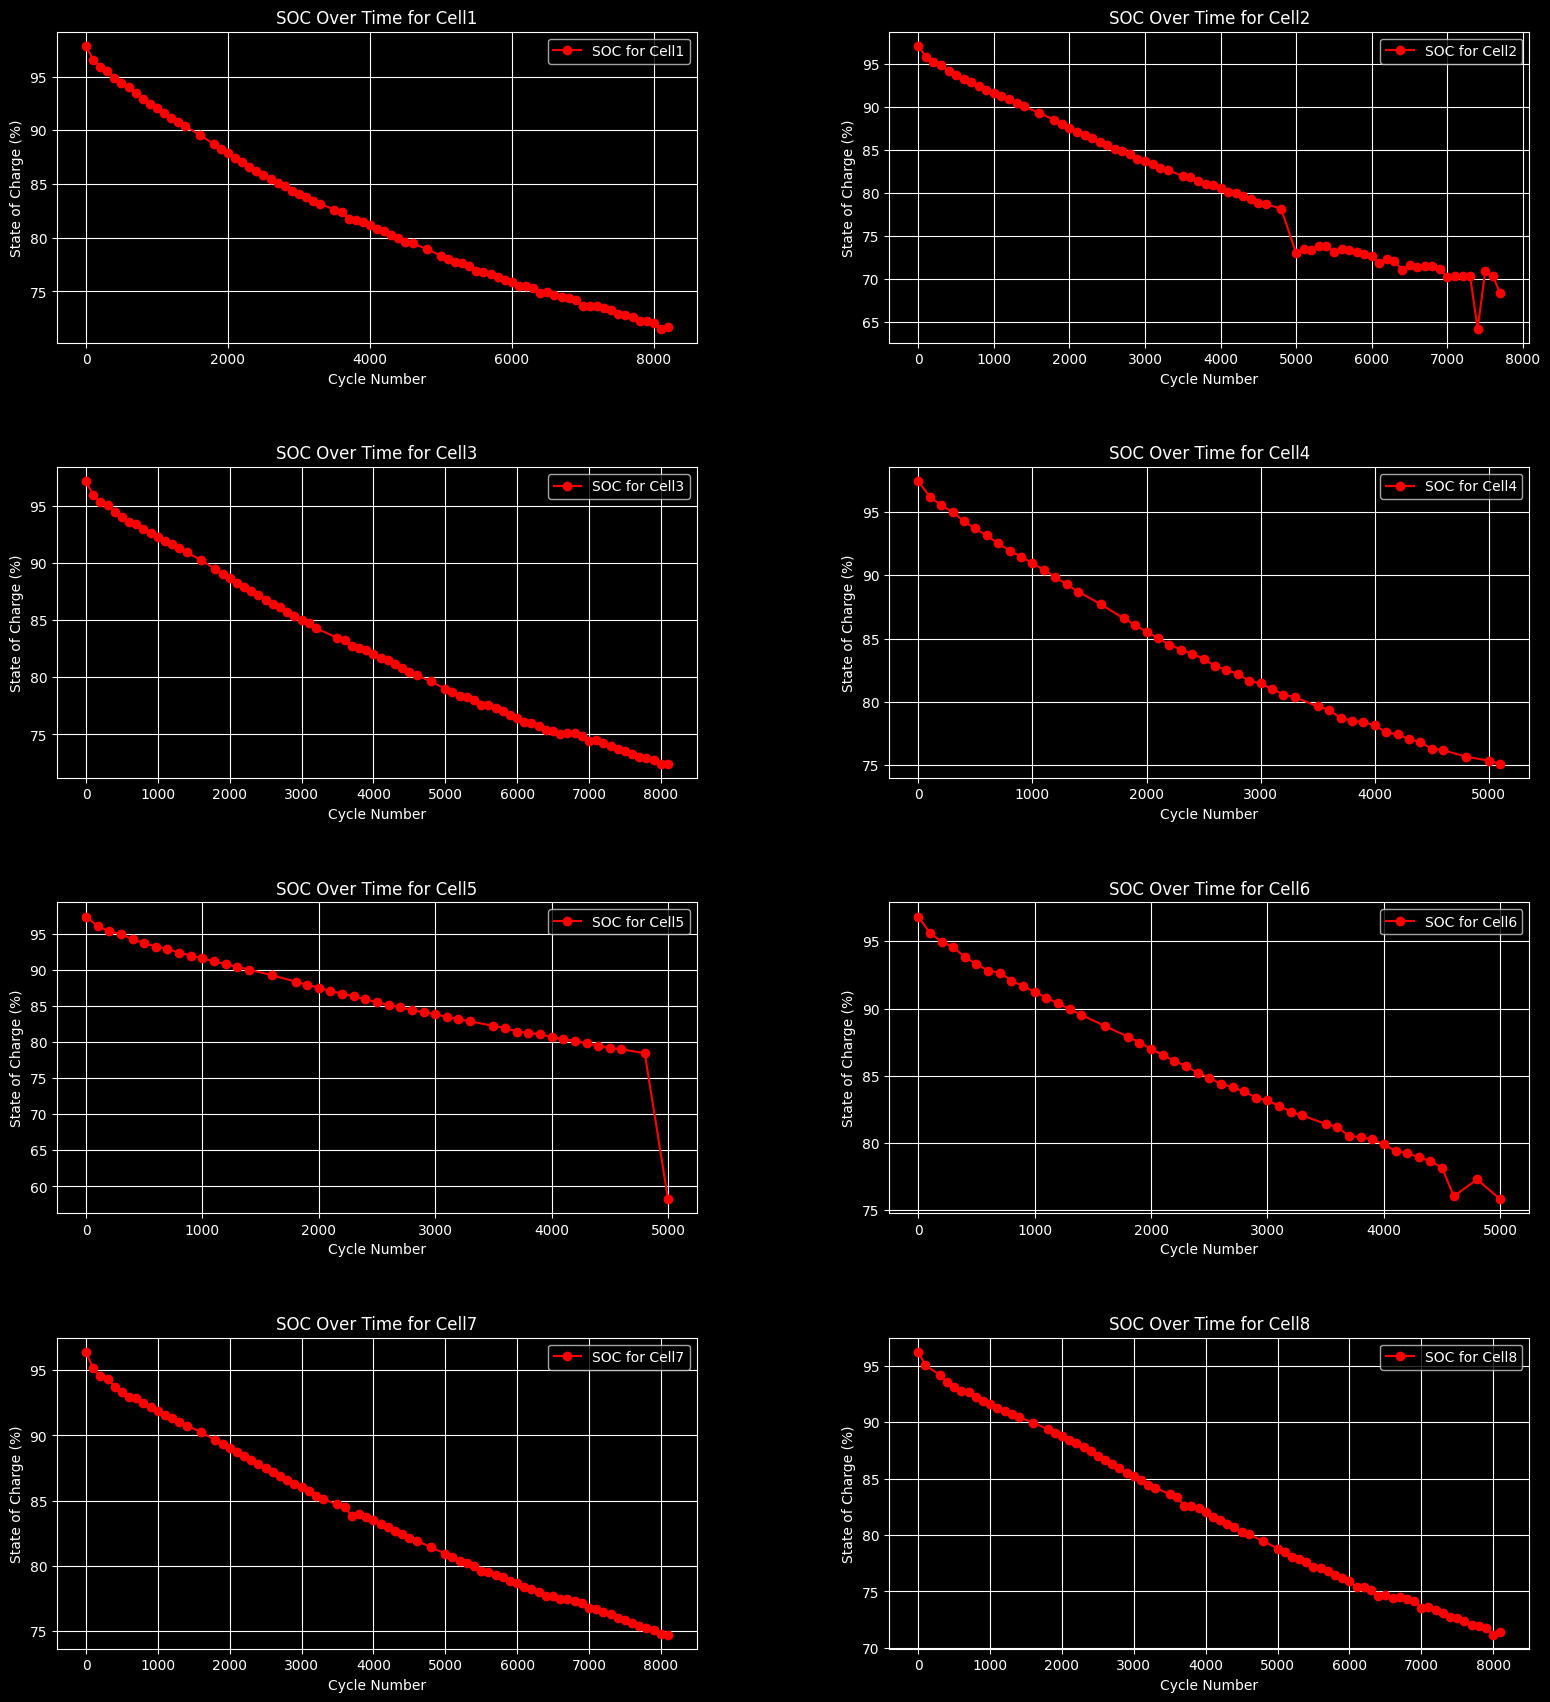

In [ ]:
initial_capacity = 740

# Setup figure for subplots
fig, axs = plt.subplots(4, 2, figsize=(19, 21))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i in range(8):
    cell_num = f'Cell{i+1}'
    cell_data = data[cell_num]

    cycle_numbers = []
    soc_values = []

    for cycle in cell_data.dtype.names:
        cycle_data = cell_data[cycle][0, 0]

        if 'C1ch' in cycle_data.dtype.names:
            charge_data = cycle_data['C1ch'][0, 0]['q'][0, 0].flatten()
            final_charge_value = charge_data[-1]

            soc = (final_charge_value / initial_capacity) * 100  # Calculate SOC

            cycle_number = int(cycle[3:])  # Extracting the cycle number from the name
            cycle_numbers.append(cycle_number)
            soc_values.append(soc)

    # Plotting SOC for this cell
    ax = axs[i // 2, i % 2]
    ax.plot(cycle_numbers, soc_values, 'ro-', label=f'SOC for {cell_num}')
    ax.set_title(f'SOC Over Time for {cell_num}')
    ax.set_xlabel('Cycle Number')
    ax.set_ylabel('State of Charge (%)')
    ax.legend()
    ax.grid(True)

plt.show()

#### Now lets perform statistics and regression analysis. As an example lets consider the Cell 8.
* We can do the same for all the cells and combine the results to get the overall analysis but due to time constraint I will be just doing for Cell 8

count    76.000000
mean     81.956933
std       7.240769
min      71.179305
25%      75.312571
50%      81.475928
75%      88.183997
max      96.210363
Name: SOC, dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    SOC   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.305e+04
Date:                Thu, 09 May 2024   Prob (F-statistic):           5.73e-85
Time:                        20:10:14   Log-Likelihood:                -61.022
No. Observations:                  76   AIC:                             126.0
Df Residuals:                      74   BIC:                             130.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err

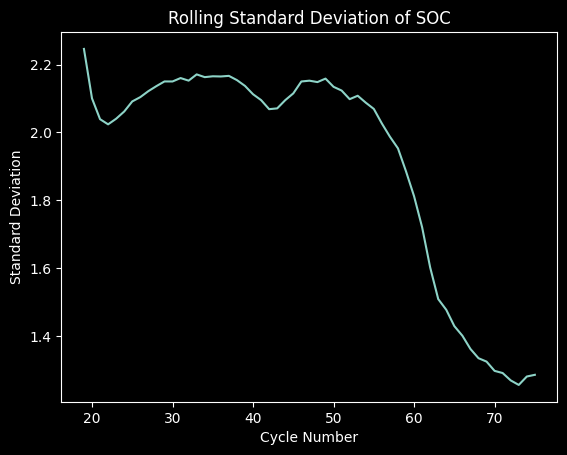

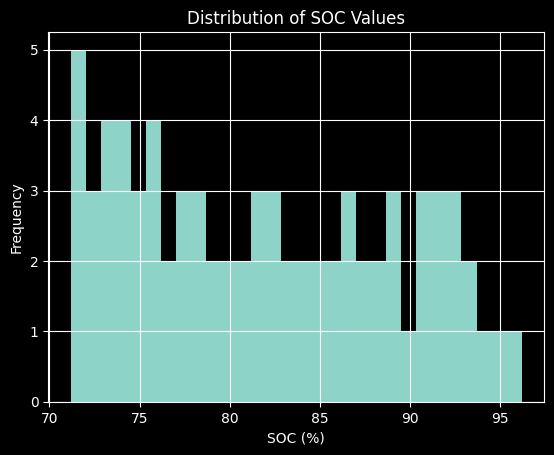

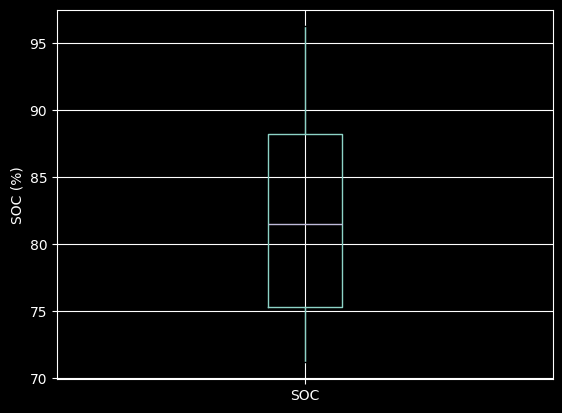

In [ ]:
# Analysis of SOC across all the cells
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'soc_values' and 'cycle_numbers' are your SOC data and corresponding cycle indices
df = pd.DataFrame({
    'Cycle': cycle_numbers,
    'SOC': soc_values
})

# Descriptive statistics
print(df['SOC'].describe())

# Linear regression for trend analysis
X = sm.add_constant(df['Cycle'])
model = sm.OLS(df['SOC'], X).fit()
print(model.summary())

# Plot rolling standard deviation
df['SOC'].rolling(window=20).std().plot(title='Rolling Standard Deviation of SOC')
plt.xlabel('Cycle Number')
plt.ylabel('Standard Deviation')
plt.show()

# Histogram of SOC values
df['SOC'].hist(bins=30)
plt.title('Distribution of SOC Values')
plt.xlabel('SOC (%)')
plt.ylabel('Frequency')
plt.show()

# Box plot for visual inspection of distribution
df.boxplot(column=['SOC'])
plt.ylabel('SOC (%)')
plt.show()


## Descriptive Statistics

- **Mean SOC (81.96%)**: This indicates that on average, the battery retains about 82% of its charge relative to its original capacity across the observed cycles. This is a central indicator of average battery performance during the observed period.
- **Standard Deviation (7.24%)**: There is a moderate variation in SOC values around the mean, indicating fluctuations in battery performance over time. A lower standard deviation would suggest more consistent performance.
- **Minimum and Maximum SOC (71.18% - 96.21%)**: The range shows the extent of SOC variation from its lowest to highest point, indicating the battery’s operational extremes.
- **Quartiles**:
  - The 25th percentile (75.31%) and 75th percentile (88.18%) suggest that 50% of the SOC values lie within this range, providing a sense of the middle 50% of the data.
  - The median SOC (81.48%) closely aligns with the mean, suggesting a relatively symmetric distribution of SOC data around the central value.

## Regression Analysis

### OLS Regression Results:
- **R-squared (0.994)**: This value is very close to 1, indicating that the model explains nearly all the variability in SOC relative to the cycles. It suggests a very high level of predictability in SOC based on cycle number.
- **F-statistic**: The very high F-statistic and its associated very small p-value suggest that the model fit is statistically significant—cycles have a significant effect on SOC.
- **Coefficients**:
  - **Intercept (94.48%)**: The model estimates that at cycle 0, the SOC would start at approximately 94.48%. This might suggest initial testing or calibration conditions.
  - **Cycle coefficient (-0.0030)**: This negative coefficient indicates that SOC decreases by 0.003% per cycle. It quantifies the rate of decline in SOC, allowing for predictions about future SOC levels.

### Diagnostic Tests:
- **Durbin-Watson (0.128)**: This low value suggests positive autocorrelation in the residuals of the regression, implying that the model might be improved (e.g., considering additional factors or using time-series specific models).
- **Condition Number (9.63e+03)**: A high condition number indicates potential multicollinearity or numerical instabilities in the model. This could be due to the scaling of the cycle numbers or inherent correlations in the predictors.


### Step 4: Feature Engineering and Algorithm Development

#### Dataset Restructuring for Modeling
* The dataframe incorporates data from all 8 cells, with SOC values calculated based on the final charge of each cycle.
* To enhance model performance, additional features have been introduced, including: final charge, average charge, final voltage, average voltage, final temperature, average temperature, and specific voltages (final and average) for different conditions like C1DC, OCVCH, and OCVDC.
* All extracted data will be consolidated into a single dataframe to facilitate modeling.

In [ ]:
# Initial full charge capacity
initial_capacity = 740

CELL_SIZE = [83, 78, 82, 52, 49, 51, 82, 82]  # Adjusted maximum cycle counts

# DataFrame to collect all data
full_data_list = []

# Iterate over each cell
for i in range(8):  # Assuming there are 8 cells
    cell_num = f'Cell{i+1}'
    cell_data = data[cell_num]

    # Maximum cycle number for the current cell
    max_cycle_number = (CELL_SIZE[i] - 1) * 100

    # Prepare a DataFrame for each cell with all expected cycles
    expected_cycles = range(0, max_cycle_number + 100, 100)
    cell_df = pd.DataFrame(index=expected_cycles, columns=[
        'cycle_number', 'cell_number', 'SOC_value', 'final_charge', 'average_charge',
        'final_voltage', 'average_voltage', 'final_temperature', 'average_temperature',
        'final_voltage_c1dc', 'average_voltage_c1dc', 'final_voltage_ocvch', 'average_voltage_ocvch',
        'final_voltage_ocvdc', 'average_voltage_ocvdc'
    ])
    cell_df['cycle_number'] = cell_df.index
    cell_df['cell_number'] = cell_num

    # Populate DataFrame with data from available cycles
    for cycle in cell_data.dtype.names:
        cycle_number = int(cycle[3:])  # Convert cycle name to integer cycle number

        # Populate data from charge cycle (C1ch)
        if 'C1ch' in cell_data[cycle][0, 0].dtype.names:
            charge_data = cell_data[cycle][0, 0]['C1ch'][0, 0]['q'][0, 0].flatten()
            voltage_data = cell_data[cycle][0, 0]['C1ch'][0, 0]['v'][0, 0].flatten()
            temperature_data = cell_data[cycle][0, 0]['C1ch'][0, 0]['T'][0, 0].flatten()

            cell_df.loc[cycle_number, 'final_charge'] = charge_data[-1]
            cell_df.loc[cycle_number, 'average_charge'] = np.mean(charge_data)
            cell_df.loc[cycle_number, 'final_voltage'] = voltage_data[-1]
            cell_df.loc[cycle_number, 'average_voltage'] = np.mean(voltage_data)
            cell_df.loc[cycle_number, 'final_temperature'] = temperature_data[-1]
            cell_df.loc[cycle_number, 'average_temperature'] = np.mean(temperature_data)
            cell_df.loc[cycle_number, 'SOC_value'] = (charge_data[-1] / initial_capacity) * 100

        # Additional checks for C1dc, OCVch, and OCVdc
        for test_type in ['C1dc', 'OCVch', 'OCVdc']:
            if test_type in cell_data[cycle][0, 0].dtype.names:
                voltage_data = cell_data[cycle][0, 0][test_type][0, 0]['v'][0, 0].flatten()
                cell_df.loc[cycle_number, f'final_voltage_{test_type.lower()}'] = voltage_data[-1]
                cell_df.loc[cycle_number, f'average_voltage_{test_type.lower()}'] = np.mean(voltage_data)

    full_data_list.append(cell_df)

full_df = pd.concat(full_data_list)
full_df.reset_index(drop=True, inplace=True)
full_df.head()

,cycle_number,cell_number,SOC_value,final_charge,average_charge,final_voltage,average_voltage,final_temperature,average_temperature,final_voltage_c1dc,average_voltage_c1dc,final_voltage_ocvch,average_voltage_ocvch,final_voltage_ocvdc,average_voltage_ocvdc
0,0.0,Cell1,97.854175,724.120891,362.101645,4.199977,3.819664,40.113808,40.049519,2.699819,3.735076,4.199857,3.793972,2.70006,3.76973
1,100.0,Cell1,96.55879,714.535043,357.357602,4.200017,3.821715,40.176216,39.993983,2.699859,3.735681,4.199777,3.794674,2.70018,3.770111
2,200.0,Cell1,95.926263,709.854346,354.941378,4.199897,3.822391,40.16375,39.992577,2.70002,3.736424,4.199777,3.795319,2.70022,3.770959
3,300.0,Cell1,95.545858,707.039349,353.572341,4.199801,3.822893,40.126312,40.006883,2.699964,3.736474,4.1996,3.796328,2.700124,3.771912
4,400.0,Cell1,94.896525,702.234286,351.183383,4.199801,3.823835,40.151283,39.988917,2.700164,3.737696,4.19976,3.79703,2.700044,3.772652


In [ ]:
full_df_test = full_df[['cell_number','cycle_number','SOC_value','final_charge','average_charge','final_voltage','average_voltage','final_temperature','average_temperature']]
import pandas as pd

for col in full_df_test.columns:
    if col != 'cell_number':
        full_df_test[col] = pd.to_numeric(full_df_test[col], errors='coerce')

full_df_test= full_df_test.fillna(full_df_test.mean(numeric_only=True)).dropna()
full_df_test['cycle_number'] = full_df_test.groupby('cell_number').cumcount() + 1
full_df_test['cycle_number'] = full_df_test['cycle_number'].astype('int')
full_df_test

/tmp/ipykernel_825270/1773749729.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df_test[col] = pd.to_numeric(full_df_test[col], errors='coerce')


,cell_number,cycle_number,SOC_value,final_charge,average_charge,final_voltage,average_voltage,final_temperature,average_temperature
0,Cell1,1,97.854175,724.120891,362.101645,4.199977,3.819664,40.113808,40.049519
1,Cell1,2,96.558790,714.535043,357.357602,4.200017,3.821715,40.176216,39.993983
2,Cell1,3,95.926263,709.854346,354.941378,4.199897,3.822391,40.163750,39.992577
3,Cell1,4,95.545858,707.039349,353.572341,4.199801,3.822893,40.126312,40.006883
4,Cell1,5,94.896525,702.234286,351.183383,4.199801,3.823835,40.151283,39.988917
...,...,...,...,...,...,...,...,...,...
555,Cell8,78,71.995724,532.768358,266.393030,4.199971,3.865455,40.580669,40.172447
556,Cell8,79,71.966855,532.554724,266.286437,4.199730,3.862435,40.630577,40.138610
557,Cell8,80,71.746571,530.924624,265.460224,4.200011,3.862736,40.568165,40.158697
558,Cell8,81,71.179305,526.726858,263.424992,4.199971,3.867927,40.668011,40.178428


#### Now we have a very structured dataset. We can start building the model that takes Voltage, current, temperature and cycle to predict the SOC for all the cells.
#### I will be using Darts library for this purpose. Darts is a Python library for easy manipulation and forecasting of time series data. It is built on top of popular libraries such as Pandas, NumPy, and scikit-learn, and provides a high-level interface for time series forecasting tasks.
#### As we are trying to predict the SOC for 8 seperate cells, this comes multi-time series regression problem.

In [ ]:
full_df_test.isnull().sum()

cell_number            0
cycle_number           0
SOC_value              0
final_charge           0
average_charge         0
final_voltage          0
average_voltage        0
final_temperature      0
average_temperature    0
dtype: int64

#### Creating Multiple Time Series for Cells Using Darts
* This section details how to construct multiple time series for each cell utilizing the Darts library. The "past covariates" refer to the features used in the model that are related to historical data points, which are instrumental in making predictions about future states.

In [ ]:
from darts.models import LightGBMModel
from darts import TimeSeries
import warnings
warnings.filterwarnings("ignore")
past_features = ['final_charge','average_charge','final_voltage','average_voltage','final_temperature','average_temperature']

series_all = TimeSeries.from_group_dataframe(full_df_test,time_col = 'cycle_number',group_cols=['cell_number'],value_cols=['final_charge','SOC_value','average_charge','final_voltage','average_voltage','final_temperature','average_temperature'])
all_past_cov =  [s[past_features] for s in series_all]

y_Train = [s[:-15] for s in series_all]
y_val = [s[-15:] for s in series_all ]

Target_train = [s['SOC_value'] for s in y_Train]
Target_val = [s['SOC_value'] for s in y_val]

/home/mibcat02/.local/lib/python3.10/site-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


#### Below is the basic LightGBM model. Later we will perform HPT to improve the model to its best

In [ ]:
model = LightGBMModel(
      lags=[-7, -15, -25],
     lags_past_covariates=4,
    output_chunk_length=3,verbose=-1)

model.fit(Target_train,past_covariates=all_past_cov)

In [ ]:
model.predict(15,Target_train,past_covariates=all_past_cov)[0].values()

array([[74.72048679],
       [74.58162648],
       [74.44323266],
       [74.54220921],
       [74.73958338],
       [74.29783002],
       [74.42723643],
       [74.29588761],
       [74.01198652],
       [74.45347407],
       [74.65822561],
       [74.34397484],
       [74.43086902],
       [74.10273414],
       [74.13403733]])

In [ ]:
Target_val[0].values()

array([[74.38639899],
       [74.20744273],
       [73.67502731],
       [73.67502731],
       [73.67607535],
       [73.46898811],
       [73.23214235],
       [72.9288328 ],
       [72.8065182 ],
       [72.64574306],
       [72.2588469 ],
       [72.26104445],
       [72.06705613],
       [71.54826193],
       [71.70217816]])

#### Model Performance Optimization Using Hyperparameter Tuning
* The model is currently not performing as anticipated. To enhance its accuracy, we will employ hyperparameter tuning (HPT) using Optuna. Key parameters to adjust include learning rate, number of leaves (num_leaves), number of estimators (n_estimators), maximum depth (max_depth), and various lags parameters (lags, lags_past_covariate, etc.).
* Due to the time constraint, I am performing HPT and predictions only for Cell 1

In [ ]:
import optuna
from darts.models import LightGBMModel
import numpy as np
import time
import pickle
import darts

past_features = ['final_charge','average_charge','final_voltage','average_voltage','final_temperature','average_temperature']

series_all = TimeSeries.from_group_dataframe(full_df_test,time_col = 'cycle_number',group_cols=['cell_number'],value_cols=['final_charge','SOC_value','average_charge','final_voltage','average_voltage','final_temperature','average_temperature'])
all_past_cov =  [s[past_features] for s in series_all]
y_Train = [s[:-15] for s in series_all]
y_val = [s[-15:] for s in series_all ]
Target_train = [s['SOC_value'] for s in y_Train]
Target_val = [s['SOC_value'] for s in y_val]

def objective(trial):
    # Hyperparameters to tune
    params = {
        'boosting_type': trial.suggest_categorical("boosting_type", ["goss", "dart", "gbdt"]),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int("num_leaves", 20, 200),
        'n_estimators': trial.suggest_int("n_estimators", 100, 300),
        'max_depth': trial.suggest_int("max_depth", 3, 20),
        'lags': trial.suggest_int("lags", 1, 30),
        'lags_past_covariates': trial.suggest_int("lags_past_covariates", 1, 10),
        'output_chunk_length': trial.suggest_int("output_chunk_length", 1, 10),
        'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
        'reg_lambda': trial.suggest_float("reg_lambda", 0, 1)
    }

    model = LightGBMModel(
        lags=[-x for x in range(1, params['lags'] + 1)],
        lags_past_covariates=params['lags_past_covariates'],
        output_chunk_length=params['output_chunk_length'],
        verbose=-1,
        **{k: v for k, v in params.items() if k not in ['lags', 'lags_past_covariates', 'output_chunk_length']}
    )

    model.fit(series=Target_train[0], past_covariates=all_past_cov[0])

    # Predict and calculate MAE
    predictions = model.predict(n=15, series=Target_train[0], past_covariates=all_past_cov[0])
    mae = np.mean([np.abs(pred.values().flatten() - val.values().flatten()).mean() for pred, val in zip(predictions, Target_val)])

    return mae

# Callback function to track progress
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")

# Optimization
start_time = time.time()
study = optuna.create_study(direction="minimize")

def print_progress(study, trial):
    elapsed_time = time.time() - start_time
    trials_done = len(study.trials)
    total_trials = 100
    estimated_total_time = (elapsed_time / trials_done) * total_trials
    remaining_time = estimated_total_time - elapsed_time
    # print(f"Trial {trials_done}/{total_trials}. Estimated remaining time: {remaining_time:.2f} seconds.")

study.optimize(objective, n_trials=50, callbacks=[print_callback, print_progress])

# Results
print('Optimization finished')
print(f"Best value (MAE): {study.best_value}")
print("Best params:")
for key, value in study.best_trial.params.items():
    print(f"{key}: {value}")

# Save the best parameters to a file
with open("best_params.pkl", "wb") as f:
    pickle.dump(study.best_trial.params, f)

# Calculate and print execution time
execution_time = time.time() - start_time
print(f"Execution time: {execution_time} seconds")

[I 2024-05-09 20:10:20,851] A new study created in memory with name: no-name-c42e20c7-7305-418f-af14-a53319efb621
[I 2024-05-09 20:10:21,005] Trial 0 finished with value: 3.0720116806841906 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13219605476022292, 'num_leaves': 44, 'n_estimators': 254, 'max_depth': 11, 'lags': 19, 'lags_past_covariates': 7, 'output_chunk_length': 1, 'reg_alpha': 0.5450230970856755, 'reg_lambda': 0.21052980024797252}. Best is trial 0 with value: 3.0720116806841906.


Current value: 3.0720116806841906, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.13219605476022292, 'num_leaves': 44, 'n_estimators': 254, 'max_depth': 11, 'lags': 19, 'lags_past_covariates': 7, 'output_chunk_length': 1, 'reg_alpha': 0.5450230970856755, 'reg_lambda': 0.21052980024797252}


[I 2024-05-09 20:10:21,138] Trial 1 finished with value: 4.932313173123294 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.03549402773511118, 'num_leaves': 92, 'n_estimators': 143, 'max_depth': 17, 'lags': 27, 'lags_past_covariates': 6, 'output_chunk_length': 10, 'reg_alpha': 0.832754794155093, 'reg_lambda': 0.4395814539482894}. Best is trial 0 with value: 3.0720116806841906.


Current value: 4.932313173123294, Current params: {'boosting_type': 'goss', 'learning_rate': 0.03549402773511118, 'num_leaves': 92, 'n_estimators': 143, 'max_depth': 17, 'lags': 27, 'lags_past_covariates': 6, 'output_chunk_length': 10, 'reg_alpha': 0.832754794155093, 'reg_lambda': 0.4395814539482894}


[I 2024-05-09 20:10:21,195] Trial 2 finished with value: 4.336154413278744 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.19066866145377584, 'num_leaves': 144, 'n_estimators': 189, 'max_depth': 19, 'lags': 6, 'lags_past_covariates': 4, 'output_chunk_length': 1, 'reg_alpha': 0.8161953185938047, 'reg_lambda': 0.0009540758780168801}. Best is trial 0 with value: 3.0720116806841906.


Current value: 4.336154413278744, Current params: {'boosting_type': 'goss', 'learning_rate': 0.19066866145377584, 'num_leaves': 144, 'n_estimators': 189, 'max_depth': 19, 'lags': 6, 'lags_past_covariates': 4, 'output_chunk_length': 1, 'reg_alpha': 0.8161953185938047, 'reg_lambda': 0.0009540758780168801}


[I 2024-05-09 20:10:21,263] Trial 3 finished with value: 4.912778393510917 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.047804515248616876, 'num_leaves': 80, 'n_estimators': 207, 'max_depth': 13, 'lags': 28, 'lags_past_covariates': 4, 'output_chunk_length': 6, 'reg_alpha': 0.6050513911085263, 'reg_lambda': 0.4946570473560403}. Best is trial 0 with value: 3.0720116806841906.


Current value: 4.912778393510917, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.047804515248616876, 'num_leaves': 80, 'n_estimators': 207, 'max_depth': 13, 'lags': 28, 'lags_past_covariates': 4, 'output_chunk_length': 6, 'reg_alpha': 0.6050513911085263, 'reg_lambda': 0.4946570473560403}


[I 2024-05-09 20:10:21,508] Trial 4 finished with value: 3.019064878218562 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.13017387732942604, 'num_leaves': 127, 'n_estimators': 219, 'max_depth': 3, 'lags': 14, 'lags_past_covariates': 3, 'output_chunk_length': 1, 'reg_alpha': 0.3979112949093453, 'reg_lambda': 0.04337726181691204}. Best is trial 4 with value: 3.019064878218562.


Current value: 3.019064878218562, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.13017387732942604, 'num_leaves': 127, 'n_estimators': 219, 'max_depth': 3, 'lags': 14, 'lags_past_covariates': 3, 'output_chunk_length': 1, 'reg_alpha': 0.3979112949093453, 'reg_lambda': 0.04337726181691204}


[I 2024-05-09 20:10:21,639] Trial 5 finished with value: 89.48490324598438 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.011990542131793416, 'num_leaves': 76, 'n_estimators': 235, 'max_depth': 15, 'lags': 2, 'lags_past_covariates': 2, 'output_chunk_length': 2, 'reg_alpha': 0.4126748892705663, 'reg_lambda': 0.575903310698097}. Best is trial 4 with value: 3.019064878218562.


Current value: 89.48490324598438, Current params: {'boosting_type': 'dart', 'learning_rate': 0.011990542131793416, 'num_leaves': 76, 'n_estimators': 235, 'max_depth': 15, 'lags': 2, 'lags_past_covariates': 2, 'output_chunk_length': 2, 'reg_alpha': 0.4126748892705663, 'reg_lambda': 0.575903310698097}


[I 2024-05-09 20:10:21,956] Trial 6 finished with value: 4.708046155591726 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.019617971682898038, 'num_leaves': 53, 'n_estimators': 260, 'max_depth': 9, 'lags': 17, 'lags_past_covariates': 4, 'output_chunk_length': 6, 'reg_alpha': 0.7435964333049715, 'reg_lambda': 0.030629897288293684}. Best is trial 4 with value: 3.019064878218562.


Current value: 4.708046155591726, Current params: {'boosting_type': 'goss', 'learning_rate': 0.019617971682898038, 'num_leaves': 53, 'n_estimators': 260, 'max_depth': 9, 'lags': 17, 'lags_past_covariates': 4, 'output_chunk_length': 6, 'reg_alpha': 0.7435964333049715, 'reg_lambda': 0.030629897288293684}


[I 2024-05-09 20:10:22,418] Trial 7 finished with value: 5.117197638976622 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.019297936472824413, 'num_leaves': 179, 'n_estimators': 153, 'max_depth': 11, 'lags': 25, 'lags_past_covariates': 6, 'output_chunk_length': 10, 'reg_alpha': 0.9216665176388213, 'reg_lambda': 0.945938098903212}. Best is trial 4 with value: 3.019064878218562.


Current value: 5.117197638976622, Current params: {'boosting_type': 'dart', 'learning_rate': 0.019297936472824413, 'num_leaves': 179, 'n_estimators': 153, 'max_depth': 11, 'lags': 25, 'lags_past_covariates': 6, 'output_chunk_length': 10, 'reg_alpha': 0.9216665176388213, 'reg_lambda': 0.945938098903212}


[I 2024-05-09 20:10:22,485] Trial 8 finished with value: 3.081236112292987 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04219471607875172, 'num_leaves': 189, 'n_estimators': 165, 'max_depth': 19, 'lags': 17, 'lags_past_covariates': 10, 'output_chunk_length': 1, 'reg_alpha': 0.47690714106068577, 'reg_lambda': 0.00844911676720661}. Best is trial 4 with value: 3.019064878218562.


Current value: 3.081236112292987, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.04219471607875172, 'num_leaves': 189, 'n_estimators': 165, 'max_depth': 19, 'lags': 17, 'lags_past_covariates': 10, 'output_chunk_length': 1, 'reg_alpha': 0.47690714106068577, 'reg_lambda': 0.00844911676720661}


[I 2024-05-09 20:10:22,597] Trial 9 finished with value: 4.579770143315081 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010901959307485116, 'num_leaves': 76, 'n_estimators': 124, 'max_depth': 4, 'lags': 14, 'lags_past_covariates': 2, 'output_chunk_length': 6, 'reg_alpha': 0.3795717470116834, 'reg_lambda': 0.7660840477415248}. Best is trial 4 with value: 3.019064878218562.


Current value: 4.579770143315081, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.010901959307485116, 'num_leaves': 76, 'n_estimators': 124, 'max_depth': 4, 'lags': 14, 'lags_past_covariates': 2, 'output_chunk_length': 6, 'reg_alpha': 0.3795717470116834, 'reg_lambda': 0.7660840477415248}


[I 2024-05-09 20:10:22,756] Trial 10 finished with value: 3.250265429956447 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.10978070668324211, 'num_leaves': 136, 'n_estimators': 292, 'max_depth': 3, 'lags': 8, 'lags_past_covariates': 1, 'output_chunk_length': 4, 'reg_alpha': 0.06979887345311919, 'reg_lambda': 0.2755739895210866}. Best is trial 4 with value: 3.019064878218562.


Current value: 3.250265429956447, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.10978070668324211, 'num_leaves': 136, 'n_estimators': 292, 'max_depth': 3, 'lags': 8, 'lags_past_covariates': 1, 'output_chunk_length': 4, 'reg_alpha': 0.06979887345311919, 'reg_lambda': 0.2755739895210866}


[I 2024-05-09 20:10:22,881] Trial 11 finished with value: 2.8986419117597855 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.16067370656100413, 'num_leaves': 24, 'n_estimators': 239, 'max_depth': 7, 'lags': 22, 'lags_past_covariates': 8, 'output_chunk_length': 3, 'reg_alpha': 0.1968103716268183, 'reg_lambda': 0.24868639858820474}. Best is trial 11 with value: 2.8986419117597855.


Current value: 2.8986419117597855, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.16067370656100413, 'num_leaves': 24, 'n_estimators': 239, 'max_depth': 7, 'lags': 22, 'lags_past_covariates': 8, 'output_chunk_length': 3, 'reg_alpha': 0.1968103716268183, 'reg_lambda': 0.24868639858820474}


[I 2024-05-09 20:10:23,010] Trial 12 finished with value: 2.906447054364838 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2870255429337271, 'num_leaves': 23, 'n_estimators': 219, 'max_depth': 7, 'lags': 23, 'lags_past_covariates': 9, 'output_chunk_length': 3, 'reg_alpha': 0.1551965875572482, 'reg_lambda': 0.23908432066396973}. Best is trial 11 with value: 2.8986419117597855.


Current value: 2.906447054364838, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.2870255429337271, 'num_leaves': 23, 'n_estimators': 219, 'max_depth': 7, 'lags': 23, 'lags_past_covariates': 9, 'output_chunk_length': 3, 'reg_alpha': 0.1551965875572482, 'reg_lambda': 0.23908432066396973}


[I 2024-05-09 20:10:23,174] Trial 13 finished with value: 3.0862539434822738 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2595874312487878, 'num_leaves': 20, 'n_estimators': 295, 'max_depth': 7, 'lags': 23, 'lags_past_covariates': 9, 'output_chunk_length': 4, 'reg_alpha': 0.11654810111960859, 'reg_lambda': 0.27559183362695244}. Best is trial 11 with value: 2.8986419117597855.


Current value: 3.0862539434822738, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.2595874312487878, 'num_leaves': 20, 'n_estimators': 295, 'max_depth': 7, 'lags': 23, 'lags_past_covariates': 9, 'output_chunk_length': 4, 'reg_alpha': 0.11654810111960859, 'reg_lambda': 0.27559183362695244}


[I 2024-05-09 20:10:23,316] Trial 14 finished with value: 2.8946464899167608 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08949255022628626, 'num_leaves': 23, 'n_estimators': 189, 'max_depth': 7, 'lags': 22, 'lags_past_covariates': 8, 'output_chunk_length': 4, 'reg_alpha': 0.2525729133308123, 'reg_lambda': 0.1900385231856957}. Best is trial 14 with value: 2.8946464899167608.


Current value: 2.8946464899167608, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.08949255022628626, 'num_leaves': 23, 'n_estimators': 189, 'max_depth': 7, 'lags': 22, 'lags_past_covariates': 8, 'output_chunk_length': 4, 'reg_alpha': 0.2525729133308123, 'reg_lambda': 0.1900385231856957}


[I 2024-05-09 20:10:23,564] Trial 15 finished with value: 100.85736190868556 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.07961567522961152, 'num_leaves': 42, 'n_estimators': 190, 'max_depth': 6, 'lags': 21, 'lags_past_covariates': 8, 'output_chunk_length': 8, 'reg_alpha': 0.24539993066987037, 'reg_lambda': 0.34423012092910266}. Best is trial 14 with value: 2.8946464899167608.


Current value: 100.85736190868556, Current params: {'boosting_type': 'dart', 'learning_rate': 0.07961567522961152, 'num_leaves': 42, 'n_estimators': 190, 'max_depth': 6, 'lags': 21, 'lags_past_covariates': 8, 'output_chunk_length': 8, 'reg_alpha': 0.24539993066987037, 'reg_lambda': 0.34423012092910266}


[I 2024-05-09 20:10:23,768] Trial 16 finished with value: 4.344598974893203 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.07434220613266927, 'num_leaves': 55, 'n_estimators': 105, 'max_depth': 9, 'lags': 30, 'lags_past_covariates': 8, 'output_chunk_length': 4, 'reg_alpha': 0.2507369114978634, 'reg_lambda': 0.15811308673632618}. Best is trial 14 with value: 2.8946464899167608.


Current value: 4.344598974893203, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.07434220613266927, 'num_leaves': 55, 'n_estimators': 105, 'max_depth': 9, 'lags': 30, 'lags_past_covariates': 8, 'output_chunk_length': 4, 'reg_alpha': 0.2507369114978634, 'reg_lambda': 0.15811308673632618}


[I 2024-05-09 20:10:23,913] Trial 17 finished with value: 3.0833382791924877 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.18172883268101525, 'num_leaves': 115, 'n_estimators': 258, 'max_depth': 9, 'lags': 22, 'lags_past_covariates': 10, 'output_chunk_length': 3, 'reg_alpha': 0.2541765673428802, 'reg_lambda': 0.6027630261976632}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.0833382791924877, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.18172883268101525, 'num_leaves': 115, 'n_estimators': 258, 'max_depth': 9, 'lags': 22, 'lags_past_covariates': 10, 'output_chunk_length': 3, 'reg_alpha': 0.2541765673428802, 'reg_lambda': 0.6027630261976632}


[I 2024-05-09 20:10:24,057] Trial 18 finished with value: 4.83139927451001 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.07276121397711557, 'num_leaves': 165, 'n_estimators': 175, 'max_depth': 5, 'lags': 11, 'lags_past_covariates': 7, 'output_chunk_length': 5, 'reg_alpha': 0.054271893067552035, 'reg_lambda': 0.15321752263177912}. Best is trial 14 with value: 2.8946464899167608.


Current value: 4.83139927451001, Current params: {'boosting_type': 'goss', 'learning_rate': 0.07276121397711557, 'num_leaves': 165, 'n_estimators': 175, 'max_depth': 5, 'lags': 11, 'lags_past_covariates': 7, 'output_chunk_length': 5, 'reg_alpha': 0.054271893067552035, 'reg_lambda': 0.15321752263177912}


[I 2024-05-09 20:10:24,294] Trial 19 finished with value: 97.78432257181393 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.10145617606571945, 'num_leaves': 36, 'n_estimators': 239, 'max_depth': 13, 'lags': 19, 'lags_past_covariates': 8, 'output_chunk_length': 8, 'reg_alpha': 0.31578150351386913, 'reg_lambda': 0.3800245349677213}. Best is trial 14 with value: 2.8946464899167608.


Current value: 97.78432257181393, Current params: {'boosting_type': 'dart', 'learning_rate': 0.10145617606571945, 'num_leaves': 36, 'n_estimators': 239, 'max_depth': 13, 'lags': 19, 'lags_past_covariates': 8, 'output_chunk_length': 8, 'reg_alpha': 0.31578150351386913, 'reg_lambda': 0.3800245349677213}


[I 2024-05-09 20:10:24,571] Trial 20 finished with value: 3.13196815172739 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.16256593277754103, 'num_leaves': 65, 'n_estimators': 276, 'max_depth': 8, 'lags': 26, 'lags_past_covariates': 5, 'output_chunk_length': 3, 'reg_alpha': 0.1754383084731758, 'reg_lambda': 0.11460441369245988}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.13196815172739, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.16256593277754103, 'num_leaves': 65, 'n_estimators': 276, 'max_depth': 8, 'lags': 26, 'lags_past_covariates': 5, 'output_chunk_length': 3, 'reg_alpha': 0.1754383084731758, 'reg_lambda': 0.11460441369245988}


[I 2024-05-09 20:10:24,719] Trial 21 finished with value: 3.069239484419235 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.27571576110688395, 'num_leaves': 20, 'n_estimators': 217, 'max_depth': 7, 'lags': 24, 'lags_past_covariates': 9, 'output_chunk_length': 3, 'reg_alpha': 0.1566452036419933, 'reg_lambda': 0.26021531821042243}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.069239484419235, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.27571576110688395, 'num_leaves': 20, 'n_estimators': 217, 'max_depth': 7, 'lags': 24, 'lags_past_covariates': 9, 'output_chunk_length': 3, 'reg_alpha': 0.1566452036419933, 'reg_lambda': 0.26021531821042243}


[I 2024-05-09 20:10:24,981] Trial 22 finished with value: 3.097201945771365 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2978753125975843, 'num_leaves': 32, 'n_estimators': 226, 'max_depth': 5, 'lags': 20, 'lags_past_covariates': 9, 'output_chunk_length': 5, 'reg_alpha': 0.01941995177086775, 'reg_lambda': 0.3595692321599376}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.097201945771365, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.2978753125975843, 'num_leaves': 32, 'n_estimators': 226, 'max_depth': 5, 'lags': 20, 'lags_past_covariates': 9, 'output_chunk_length': 5, 'reg_alpha': 0.01941995177086775, 'reg_lambda': 0.3595692321599376}


[I 2024-05-09 20:10:25,068] Trial 23 finished with value: 4.511383810591035 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.20072866845284285, 'num_leaves': 20, 'n_estimators': 197, 'max_depth': 7, 'lags': 29, 'lags_past_covariates': 7, 'output_chunk_length': 2, 'reg_alpha': 0.1964275076832508, 'reg_lambda': 0.1174176310303393}. Best is trial 14 with value: 2.8946464899167608.


Current value: 4.511383810591035, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.20072866845284285, 'num_leaves': 20, 'n_estimators': 197, 'max_depth': 7, 'lags': 29, 'lags_past_covariates': 7, 'output_chunk_length': 2, 'reg_alpha': 0.1964275076832508, 'reg_lambda': 0.1174176310303393}


[I 2024-05-09 20:10:25,180] Trial 24 finished with value: 3.062435376566719 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.23093259854436754, 'num_leaves': 93, 'n_estimators': 179, 'max_depth': 10, 'lags': 23, 'lags_past_covariates': 10, 'output_chunk_length': 2, 'reg_alpha': 0.32121820069321166, 'reg_lambda': 0.2066448136266733}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.062435376566719, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.23093259854436754, 'num_leaves': 93, 'n_estimators': 179, 'max_depth': 10, 'lags': 23, 'lags_past_covariates': 10, 'output_chunk_length': 2, 'reg_alpha': 0.32121820069321166, 'reg_lambda': 0.2066448136266733}


[I 2024-05-09 20:10:25,344] Trial 25 finished with value: 3.1454753211377584 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14142295474963212, 'num_leaves': 61, 'n_estimators': 244, 'max_depth': 5, 'lags': 16, 'lags_past_covariates': 8, 'output_chunk_length': 4, 'reg_alpha': 0.1243036255167635, 'reg_lambda': 0.3126644287188097}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.1454753211377584, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.14142295474963212, 'num_leaves': 61, 'n_estimators': 244, 'max_depth': 5, 'lags': 16, 'lags_past_covariates': 8, 'output_chunk_length': 4, 'reg_alpha': 0.1243036255167635, 'reg_lambda': 0.3126644287188097}


[I 2024-05-09 20:10:25,479] Trial 26 finished with value: 3.099917852206022 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09745536666059154, 'num_leaves': 31, 'n_estimators': 205, 'max_depth': 8, 'lags': 25, 'lags_past_covariates': 9, 'output_chunk_length': 3, 'reg_alpha': 0.0019430931297788057, 'reg_lambda': 0.4771309995081414}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.099917852206022, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.09745536666059154, 'num_leaves': 31, 'n_estimators': 205, 'max_depth': 8, 'lags': 25, 'lags_past_covariates': 9, 'output_chunk_length': 3, 'reg_alpha': 0.0019430931297788057, 'reg_lambda': 0.4771309995081414}


[I 2024-05-09 20:10:25,673] Trial 27 finished with value: 3.12155829829589 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.062425546230631984, 'num_leaves': 47, 'n_estimators': 233, 'max_depth': 12, 'lags': 21, 'lags_past_covariates': 7, 'output_chunk_length': 5, 'reg_alpha': 0.6304579163092769, 'reg_lambda': 0.399897017820938}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.12155829829589, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.062425546230631984, 'num_leaves': 47, 'n_estimators': 233, 'max_depth': 12, 'lags': 21, 'lags_past_covariates': 7, 'output_chunk_length': 5, 'reg_alpha': 0.6304579163092769, 'reg_lambda': 0.399897017820938}


[I 2024-05-09 20:10:25,888] Trial 28 finished with value: 98.08474733554465 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.2161763843124414, 'num_leaves': 34, 'n_estimators': 214, 'max_depth': 6, 'lags': 18, 'lags_past_covariates': 6, 'output_chunk_length': 7, 'reg_alpha': 0.27687610659689404, 'reg_lambda': 0.5969808656504012}. Best is trial 14 with value: 2.8946464899167608.


Current value: 98.08474733554465, Current params: {'boosting_type': 'dart', 'learning_rate': 0.2161763843124414, 'num_leaves': 34, 'n_estimators': 214, 'max_depth': 6, 'lags': 18, 'lags_past_covariates': 6, 'output_chunk_length': 7, 'reg_alpha': 0.27687610659689404, 'reg_lambda': 0.5969808656504012}


[I 2024-05-09 20:10:26,001] Trial 29 finished with value: 4.021817327804944 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.13822743987916267, 'num_leaves': 44, 'n_estimators': 273, 'max_depth': 10, 'lags': 19, 'lags_past_covariates': 7, 'output_chunk_length': 2, 'reg_alpha': 0.4990217879295901, 'reg_lambda': 0.20961010401351038}. Best is trial 14 with value: 2.8946464899167608.


Current value: 4.021817327804944, Current params: {'boosting_type': 'goss', 'learning_rate': 0.13822743987916267, 'num_leaves': 44, 'n_estimators': 273, 'max_depth': 10, 'lags': 19, 'lags_past_covariates': 7, 'output_chunk_length': 2, 'reg_alpha': 0.4990217879295901, 'reg_lambda': 0.20961010401351038}


[I 2024-05-09 20:10:26,148] Trial 30 finished with value: 3.195335594873855 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.033106597872552025, 'num_leaves': 66, 'n_estimators': 249, 'max_depth': 4, 'lags': 13, 'lags_past_covariates': 9, 'output_chunk_length': 3, 'reg_alpha': 0.09325928453982194, 'reg_lambda': 0.09640258834662933}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.195335594873855, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.033106597872552025, 'num_leaves': 66, 'n_estimators': 249, 'max_depth': 4, 'lags': 13, 'lags_past_covariates': 9, 'output_chunk_length': 3, 'reg_alpha': 0.09325928453982194, 'reg_lambda': 0.09640258834662933}


[I 2024-05-09 20:10:26,248] Trial 31 finished with value: 3.014992155662728 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.11257989814940753, 'num_leaves': 122, 'n_estimators': 225, 'max_depth': 4, 'lags': 14, 'lags_past_covariates': 3, 'output_chunk_length': 1, 'reg_alpha': 0.39440195399459377, 'reg_lambda': 0.08414653149076287}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.014992155662728, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.11257989814940753, 'num_leaves': 122, 'n_estimators': 225, 'max_depth': 4, 'lags': 14, 'lags_past_covariates': 3, 'output_chunk_length': 1, 'reg_alpha': 0.39440195399459377, 'reg_lambda': 0.08414653149076287}


[I 2024-05-09 20:10:26,463] Trial 32 finished with value: 3.145357554040438 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.12153711344314942, 'num_leaves': 112, 'n_estimators': 223, 'max_depth': 6, 'lags': 11, 'lags_past_covariates': 5, 'output_chunk_length': 2, 'reg_alpha': 0.36310508952803483, 'reg_lambda': 0.19403070255664998}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.145357554040438, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.12153711344314942, 'num_leaves': 112, 'n_estimators': 223, 'max_depth': 6, 'lags': 11, 'lags_past_covariates': 5, 'output_chunk_length': 2, 'reg_alpha': 0.36310508952803483, 'reg_lambda': 0.19403070255664998}


[I 2024-05-09 20:10:26,697] Trial 33 finished with value: 3.0993112783065806 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.16449714685952474, 'num_leaves': 99, 'n_estimators': 200, 'max_depth': 4, 'lags': 27, 'lags_past_covariates': 8, 'output_chunk_length': 1, 'reg_alpha': 0.2060518704502649, 'reg_lambda': 0.08056109368221409}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.0993112783065806, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.16449714685952474, 'num_leaves': 99, 'n_estimators': 200, 'max_depth': 4, 'lags': 27, 'lags_past_covariates': 8, 'output_chunk_length': 1, 'reg_alpha': 0.2060518704502649, 'reg_lambda': 0.08056109368221409}


[I 2024-05-09 20:10:26,871] Trial 34 finished with value: 3.1354889140333277 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08977134243998988, 'num_leaves': 140, 'n_estimators': 180, 'max_depth': 8, 'lags': 11, 'lags_past_covariates': 6, 'output_chunk_length': 4, 'reg_alpha': 0.44889969244003103, 'reg_lambda': 0.23533809968553204}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.1354889140333277, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.08977134243998988, 'num_leaves': 140, 'n_estimators': 180, 'max_depth': 8, 'lags': 11, 'lags_past_covariates': 6, 'output_chunk_length': 4, 'reg_alpha': 0.44889969244003103, 'reg_lambda': 0.23533809968553204}


[I 2024-05-09 20:10:26,963] Trial 35 finished with value: 4.241356562033811 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.05954004164813581, 'num_leaves': 158, 'n_estimators': 210, 'max_depth': 3, 'lags': 15, 'lags_past_covariates': 3, 'output_chunk_length': 1, 'reg_alpha': 0.5435738641848343, 'reg_lambda': 0.43797224590307887}. Best is trial 14 with value: 2.8946464899167608.


Current value: 4.241356562033811, Current params: {'boosting_type': 'goss', 'learning_rate': 0.05954004164813581, 'num_leaves': 158, 'n_estimators': 210, 'max_depth': 3, 'lags': 15, 'lags_past_covariates': 3, 'output_chunk_length': 1, 'reg_alpha': 0.5435738641848343, 'reg_lambda': 0.43797224590307887}


[I 2024-05-09 20:10:27,119] Trial 36 finished with value: 3.077145634452469 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.14859253062790978, 'num_leaves': 120, 'n_estimators': 270, 'max_depth': 6, 'lags': 8, 'lags_past_covariates': 5, 'output_chunk_length': 3, 'reg_alpha': 0.3149777711491233, 'reg_lambda': 0.16449360652221856}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.077145634452469, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.14859253062790978, 'num_leaves': 120, 'n_estimators': 270, 'max_depth': 6, 'lags': 8, 'lags_past_covariates': 5, 'output_chunk_length': 3, 'reg_alpha': 0.3149777711491233, 'reg_lambda': 0.16449360652221856}


[I 2024-05-09 20:10:27,247] Trial 37 finished with value: 3.1859209746445325 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.23875139769381024, 'num_leaves': 153, 'n_estimators': 228, 'max_depth': 17, 'lags': 21, 'lags_past_covariates': 1, 'output_chunk_length': 2, 'reg_alpha': 0.4287591597116529, 'reg_lambda': 0.31288044096441375}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.1859209746445325, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.23875139769381024, 'num_leaves': 153, 'n_estimators': 228, 'max_depth': 17, 'lags': 21, 'lags_past_covariates': 1, 'output_chunk_length': 2, 'reg_alpha': 0.4287591597116529, 'reg_lambda': 0.31288044096441375}


[I 2024-05-09 20:10:27,354] Trial 38 finished with value: 4.840204101735674 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.11523454455284343, 'num_leaves': 105, 'n_estimators': 160, 'max_depth': 11, 'lags': 27, 'lags_past_covariates': 3, 'output_chunk_length': 5, 'reg_alpha': 0.5711197782898328, 'reg_lambda': 0.060900065113414475}. Best is trial 14 with value: 2.8946464899167608.


Current value: 4.840204101735674, Current params: {'boosting_type': 'goss', 'learning_rate': 0.11523454455284343, 'num_leaves': 105, 'n_estimators': 160, 'max_depth': 11, 'lags': 27, 'lags_past_covariates': 3, 'output_chunk_length': 5, 'reg_alpha': 0.5711197782898328, 'reg_lambda': 0.060900065113414475}


[I 2024-05-09 20:10:27,468] Trial 39 finished with value: 3.088653286247024 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.048464308434877174, 'num_leaves': 128, 'n_estimators': 135, 'max_depth': 7, 'lags': 4, 'lags_past_covariates': 10, 'output_chunk_length': 1, 'reg_alpha': 0.6575074913678223, 'reg_lambda': 0.5363260393647058}. Best is trial 14 with value: 2.8946464899167608.


Current value: 3.088653286247024, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.048464308434877174, 'num_leaves': 128, 'n_estimators': 135, 'max_depth': 7, 'lags': 4, 'lags_past_covariates': 10, 'output_chunk_length': 1, 'reg_alpha': 0.6575074913678223, 'reg_lambda': 0.5363260393647058}


[I 2024-05-09 20:10:27,660] Trial 40 finished with value: 2.8580622077143807 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17506299271560752, 'num_leaves': 90, 'n_estimators': 191, 'max_depth': 5, 'lags': 17, 'lags_past_covariates': 7, 'output_chunk_length': 4, 'reg_alpha': 0.3573674949406625, 'reg_lambda': 0.6510748061613332}. Best is trial 40 with value: 2.8580622077143807.


Current value: 2.8580622077143807, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.17506299271560752, 'num_leaves': 90, 'n_estimators': 191, 'max_depth': 5, 'lags': 17, 'lags_past_covariates': 7, 'output_chunk_length': 4, 'reg_alpha': 0.3573674949406625, 'reg_lambda': 0.6510748061613332}


[I 2024-05-09 20:10:27,905] Trial 41 finished with value: 2.913367549843389 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.17687688288252337, 'num_leaves': 84, 'n_estimators': 193, 'max_depth': 5, 'lags': 18, 'lags_past_covariates': 7, 'output_chunk_length': 4, 'reg_alpha': 0.3469152381728168, 'reg_lambda': 0.704138726542084}. Best is trial 40 with value: 2.8580622077143807.


Current value: 2.913367549843389, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.17687688288252337, 'num_leaves': 84, 'n_estimators': 193, 'max_depth': 5, 'lags': 18, 'lags_past_covariates': 7, 'output_chunk_length': 4, 'reg_alpha': 0.3469152381728168, 'reg_lambda': 0.704138726542084}


[I 2024-05-09 20:10:28,106] Trial 42 finished with value: 2.899785158328985 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.18414591065342975, 'num_leaves': 80, 'n_estimators': 192, 'max_depth': 5, 'lags': 17, 'lags_past_covariates': 8, 'output_chunk_length': 4, 'reg_alpha': 0.3375292046011861, 'reg_lambda': 0.685466623509873}. Best is trial 40 with value: 2.8580622077143807.


Current value: 2.899785158328985, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.18414591065342975, 'num_leaves': 80, 'n_estimators': 192, 'max_depth': 5, 'lags': 17, 'lags_past_covariates': 8, 'output_chunk_length': 4, 'reg_alpha': 0.3375292046011861, 'reg_lambda': 0.685466623509873}


[I 2024-05-09 20:10:28,279] Trial 43 finished with value: 3.5772513522034775 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2022792505723636, 'num_leaves': 74, 'n_estimators': 171, 'max_depth': 8, 'lags': 23, 'lags_past_covariates': 8, 'output_chunk_length': 6, 'reg_alpha': 0.9924728092520648, 'reg_lambda': 0.7032626650131036}. Best is trial 40 with value: 2.8580622077143807.


Current value: 3.5772513522034775, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.2022792505723636, 'num_leaves': 74, 'n_estimators': 171, 'max_depth': 8, 'lags': 23, 'lags_past_covariates': 8, 'output_chunk_length': 6, 'reg_alpha': 0.9924728092520648, 'reg_lambda': 0.7032626650131036}


[I 2024-05-09 20:10:28,449] Trial 44 finished with value: 101.15492791241525 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.2504129782842471, 'num_leaves': 84, 'n_estimators': 187, 'max_depth': 3, 'lags': 20, 'lags_past_covariates': 9, 'output_chunk_length': 4, 'reg_alpha': 0.20274133540125117, 'reg_lambda': 0.8902565217523145}. Best is trial 40 with value: 2.8580622077143807.


Current value: 101.15492791241525, Current params: {'boosting_type': 'dart', 'learning_rate': 0.2504129782842471, 'num_leaves': 84, 'n_estimators': 187, 'max_depth': 3, 'lags': 20, 'lags_past_covariates': 9, 'output_chunk_length': 4, 'reg_alpha': 0.20274133540125117, 'reg_lambda': 0.8902565217523145}


[I 2024-05-09 20:10:28,604] Trial 45 finished with value: 3.131606371578762 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2003218830518327, 'num_leaves': 55, 'n_estimators': 159, 'max_depth': 15, 'lags': 16, 'lags_past_covariates': 8, 'output_chunk_length': 5, 'reg_alpha': 0.2900540585760499, 'reg_lambda': 0.8089274525438677}. Best is trial 40 with value: 2.8580622077143807.


Current value: 3.131606371578762, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.2003218830518327, 'num_leaves': 55, 'n_estimators': 159, 'max_depth': 15, 'lags': 16, 'lags_past_covariates': 8, 'output_chunk_length': 5, 'reg_alpha': 0.2900540585760499, 'reg_lambda': 0.8089274525438677}


[I 2024-05-09 20:10:28,749] Trial 46 finished with value: 3.187673109841988 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.028435046806658502, 'num_leaves': 27, 'n_estimators': 206, 'max_depth': 20, 'lags': 25, 'lags_past_covariates': 7, 'output_chunk_length': 3, 'reg_alpha': 0.15380006144669345, 'reg_lambda': 0.6699428751793898}. Best is trial 40 with value: 2.8580622077143807.


Current value: 3.187673109841988, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.028435046806658502, 'num_leaves': 27, 'n_estimators': 206, 'max_depth': 20, 'lags': 25, 'lags_past_covariates': 7, 'output_chunk_length': 3, 'reg_alpha': 0.15380006144669345, 'reg_lambda': 0.6699428751793898}


[I 2024-05-09 20:10:28,887] Trial 47 finished with value: 2.8560771473945152 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.2975648138962, 'num_leaves': 42, 'n_estimators': 145, 'max_depth': 6, 'lags': 17, 'lags_past_covariates': 6, 'output_chunk_length': 4, 'reg_alpha': 0.224475565587962, 'reg_lambda': 0.7967692275961518}. Best is trial 47 with value: 2.8560771473945152.


Current value: 2.8560771473945152, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.2975648138962, 'num_leaves': 42, 'n_estimators': 145, 'max_depth': 6, 'lags': 17, 'lags_past_covariates': 6, 'output_chunk_length': 4, 'reg_alpha': 0.224475565587962, 'reg_lambda': 0.7967692275961518}


[I 2024-05-09 20:10:29,035] Trial 48 finished with value: 2.9474399685816435 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.1512200329933429, 'num_leaves': 42, 'n_estimators': 144, 'max_depth': 6, 'lags': 17, 'lags_past_covariates': 6, 'output_chunk_length': 4, 'reg_alpha': 0.23224386143332756, 'reg_lambda': 0.8244496441373165}. Best is trial 47 with value: 2.8560771473945152.


Current value: 2.9474399685816435, Current params: {'boosting_type': 'gbdt', 'learning_rate': 0.1512200329933429, 'num_leaves': 42, 'n_estimators': 144, 'max_depth': 6, 'lags': 17, 'lags_past_covariates': 6, 'output_chunk_length': 4, 'reg_alpha': 0.23224386143332756, 'reg_lambda': 0.8244496441373165}


[I 2024-05-09 20:10:29,211] Trial 49 finished with value: 4.922264420889922 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.08289627432756128, 'num_leaves': 71, 'n_estimators': 122, 'max_depth': 10, 'lags': 12, 'lags_past_covariates': 7, 'output_chunk_length': 6, 'reg_alpha': 0.4688770626694322, 'reg_lambda': 0.6406615803783485}. Best is trial 47 with value: 2.8560771473945152.


Current value: 4.922264420889922, Current params: {'boosting_type': 'goss', 'learning_rate': 0.08289627432756128, 'num_leaves': 71, 'n_estimators': 122, 'max_depth': 10, 'lags': 12, 'lags_past_covariates': 7, 'output_chunk_length': 6, 'reg_alpha': 0.4688770626694322, 'reg_lambda': 0.6406615803783485}
Optimization finished
Best value (MAE): 2.8560771473945152
Best params:
boosting_type: gbdt
learning_rate: 0.2975648138962
num_leaves: 42
n_estimators: 145
max_depth: 6
lags: 17
lags_past_covariates: 6
output_chunk_length: 4
reg_alpha: 0.224475565587962
reg_lambda: 0.7967692275961518
Execution time: 8.377562522888184 seconds


In [ ]:
best_params = study.best_trial.params

In [ ]:
best_model = LightGBMModel(
    lags=[-x for x in range(1, best_params['lags'] + 1)],
    lags_past_covariates=best_params['lags_past_covariates'],
    output_chunk_length=best_params['output_chunk_length'],
    verbose=-1,
    **{k: v for k, v in best_params.items() if k not in ['lags', 'lags_past_covariates', 'output_chunk_length']}
)
best_model.fit(series=Target_train[0], past_covariates=all_past_cov[0])

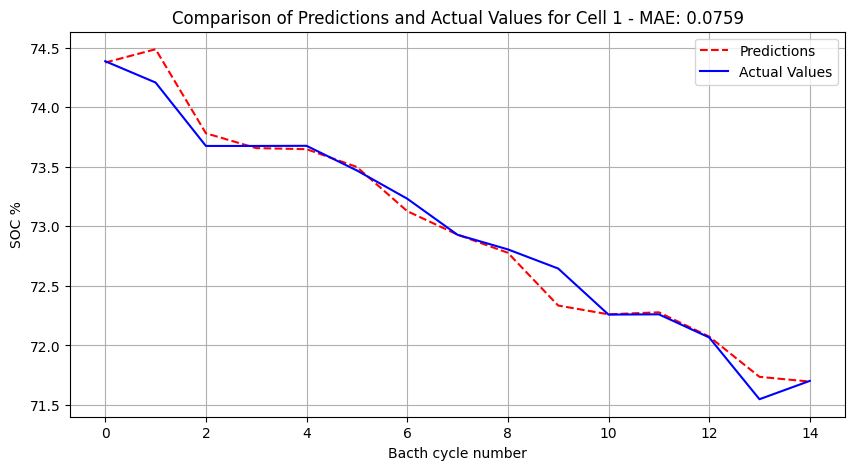

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()

predictions = best_model.predict(15, Target_train[0]).values().flatten()
actuals = Target_val[0].values().flatten()
mae = np.mean(np.abs(predictions - actuals))

plt.figure(figsize=(10, 5))
plt.plot(predictions, label='Predictions', color='red', linestyle='--')
plt.plot(actuals, label='Actual Values', color='blue')

plt.title(f'Comparison of Predictions and Actual Values for Cell 1 - MAE: {mae:.4f}')
plt.xlabel('Batch cycle number')
plt.ylabel('SOC %')
plt.legend()
plt.grid(True)

plt.show()

#### Results After Hyperparameter Tuning with Optuna
* Following the hyperparameter tuning using Optuna, the model showed excellent performance on the validation data for Cell 1, which includes the last 15 cycles of the dataset. The model achieved a remarkably low Mean Absolute Error (MAE) of 0.0759.
* Applying scaling and transformation techniques, such as differencing transforms or MinMaxScaler scaling, can significantly enhance the model's predictive accuracy.

#### Introduction to Chronos: A Popular Time Series Forecasting Model
* **Chronos** is a univariate time series forecasting model. It is a transformers-based model, pretrained on an extensive collection of time series data, making it highly effective for forecasting tasks that involve a single feature.
* Developed by Amazon's team, Chronos offers the advantage of requiring no initial training. While fine-tuning is possible with custom data, it will not be covered in this test.

In [ ]:
from chronos import ChronosPipeline
import torch

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cuda",
    torch_dtype=torch.bfloat16,
)

In [ ]:
Input_data_series = full_df_test[full_df_test['cell_number']=='Cell1']['SOC_value'].values[:-5]

In [ ]:
context = torch.tensor(full_df_test[full_df_test['cell_number']=='Cell1']['SOC_value'].values[:-5], dtype=torch.float32).unsqueeze(0)

prediction_length = 5

forecast = pipeline.predict(
    context=context,
    prediction_length=prediction_length,
    num_samples=20,
    temperature=1.0,
    top_k=50,
    top_p=1.0
)

In [ ]:
low, median, high = np.quantile(forecast[0].numpy(), [0.05, 0.1, 0.95], axis=0)

In [ ]:
predictions = np.array(median)
actual = np.array(full_df_test[full_df_test['cell_number']=='Cell1']['SOC_value'].values[-5:])

In [ ]:
mae = np.mean(np.abs(predictions - actual))
mae

0.3193882720895914

#### Performance and Fine-Tuning of the Model
* Without any training and utilizing minimal resources, we achieved a Mean Absolute Error (MAE) of 0.310, which is commendable. However, there is potential for further improvement through fine-tuning the model, potentially reducing the MAE to below 0.05.

### Step 5: Theoretical Deployment Using KServe

* Initially, training and inference pipelines will be established within the Kubeflow environment, and scheduled as required.
* Model training will occur as needed—typically upon encountering new data or when performance metrics decline—to ensure the model remains optimal.
* After training, the model's pickle files will be saved to a Persistent Volume Claim (PVC) or an S3 bucket for persistence.
* A Docker container will be created to serve the model. This container will include all necessary libraries and will be configured to load the LightGBM model and handle prediction requests effectively.
* Deployment of the model involves using KServe to create an InferenceService definition, which manages how the model is served.
* Once deployed, predictions can be requested from the service's endpoint provided by KServe. You will need to verify the external IP and port as exposed by your Kubernetes cluster to access the service.
* For models requiring GPU resources for inference, such as large language models (LLMs), deploying with a Triton server is recommended to handle the computational demands efficiently.